In [1]:
import pandas as pd
import numpy as np
from patternly.detection import ContinuousStreamingDetection
from IPython.display import Image, display
from IPython.core.display import HTML

In [2]:
original = pd.read_csv("./data/01_2015_LANL-01A_SOPA_MPA.txt",low_memory=False).dropna(how="any", axis=0)

In [3]:
# parameters for patternly
start_col = 0
end_col = 3
window_size = 1000
window_overlap = 0

In [4]:
# split data for each channel into sequences and continuously update PFSA library if a given
# sequence does not conform to any PFSAs in the established library
pipelines = []
predictions = pd.DataFrame()
for i in range(start_col, end_col):
    data = original.iloc[:,i+1].reset_index(drop=True).replace(-1e+31, np.nan).dropna(how="all", axis=0)
    pipelines.append(
        ContinuousStreamingDetection(
            window_size=window_size,
            window_overlap=window_overlap,
            quantize_type="simple",
            eps=0.05,
            verbose=False,
            reduce_clusters = False,
        )
    )
    pipelines[i - start_col].fit_stream(data)
    predictions = pd.concat([predictions, pd.DataFrame(pipelines[i - start_col].predict())], axis=1)

predictions.columns = range(predictions.shape[1])

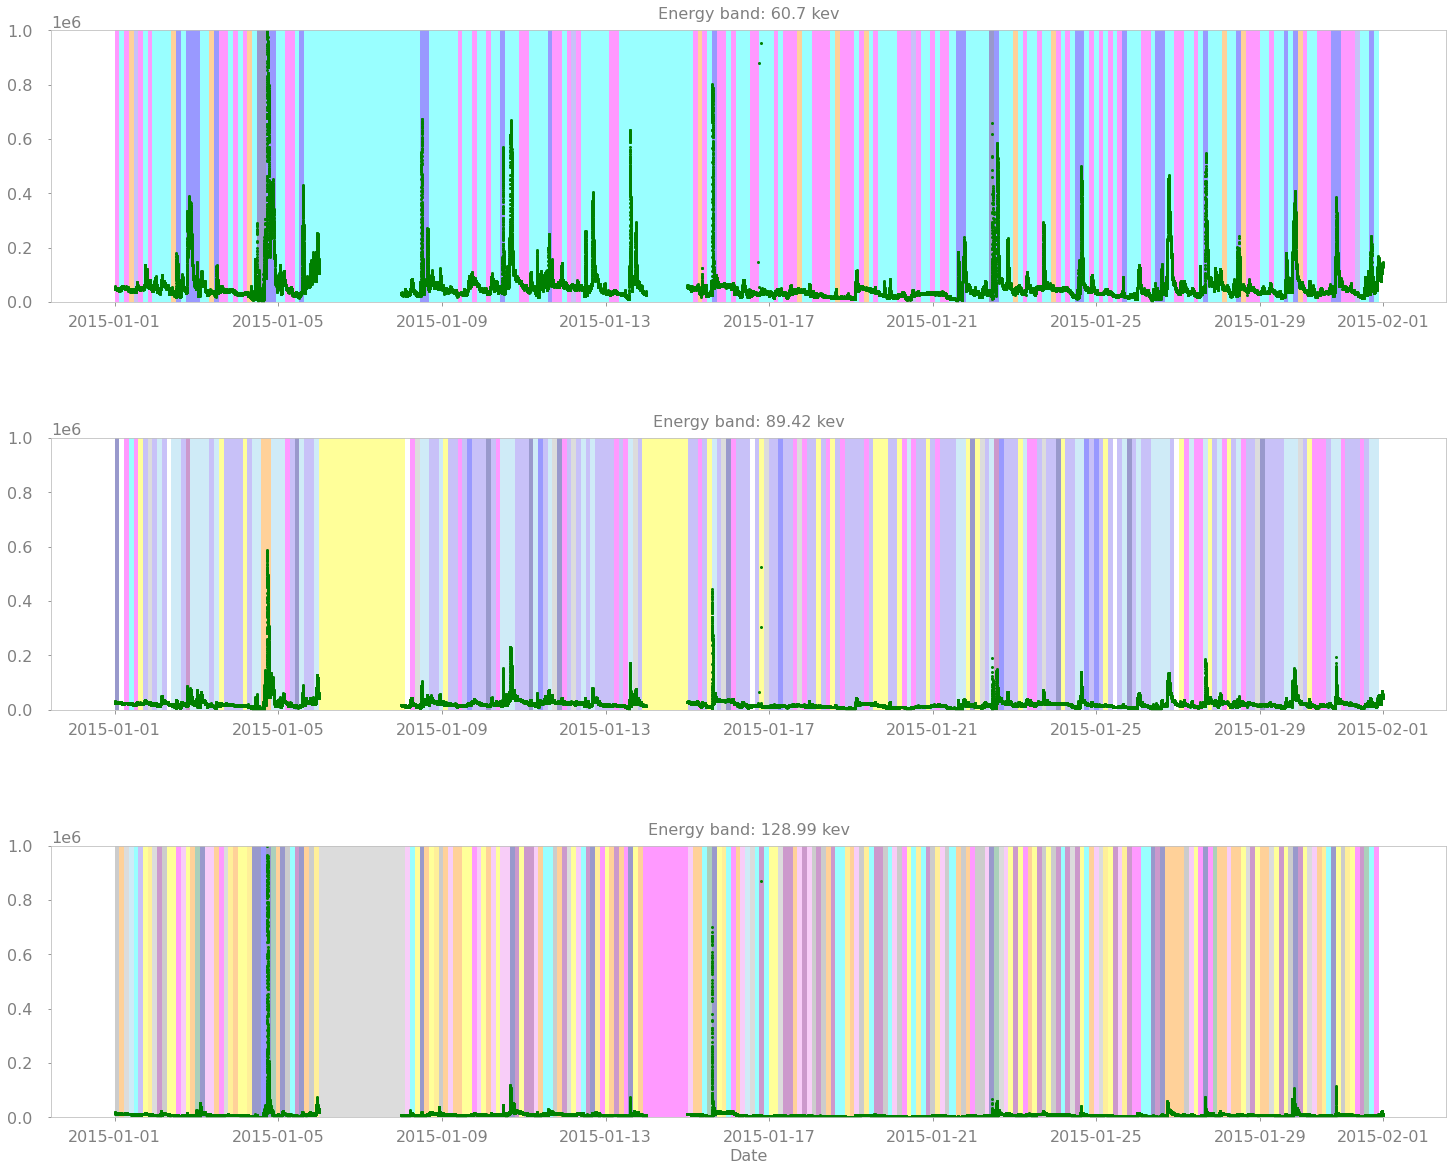

In [7]:
# plot data with coloring of active PFSAs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original.iloc[:,0][0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original.iloc[:,0][original.shape[0]-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

for i in range(end_col-start_col):
    seqs = original.iloc[:,i+1].to_frame().replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    # rank clusters for coloring
    cluster_counts = [0 for j in range(pipelines[i].n_clusters)]
    for cluster in pipelines[i].closest_match:
        cluster_counts[cluster] += 1
    cluster_rank = np.flip(np.argsort(cluster_counts))
        
    for index in predictions.index:
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        colors = [
            "#7766ee", "blue", "magenta", "darkorange", 'cyan', "navy", "yellow", "darkgray", "white", "purple", "skyblue", "gray",
            "violet", "gold", "seagreen", "lime"
        ]
        plt.axvspan(beg, end, color=colors[cluster_rank[pipelines[i].closest_match[index]]], alpha=0.4, lw=0)

        
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev',fontsize=16,y=1.02,color='.5')
    if i == end_col-1:
        ax.set_xlabel('Date',fontsize=16, color='.5')
        
plt.savefig('anomaly_result1.png',dpi=300,bbox_inches='tight',transparent=True)

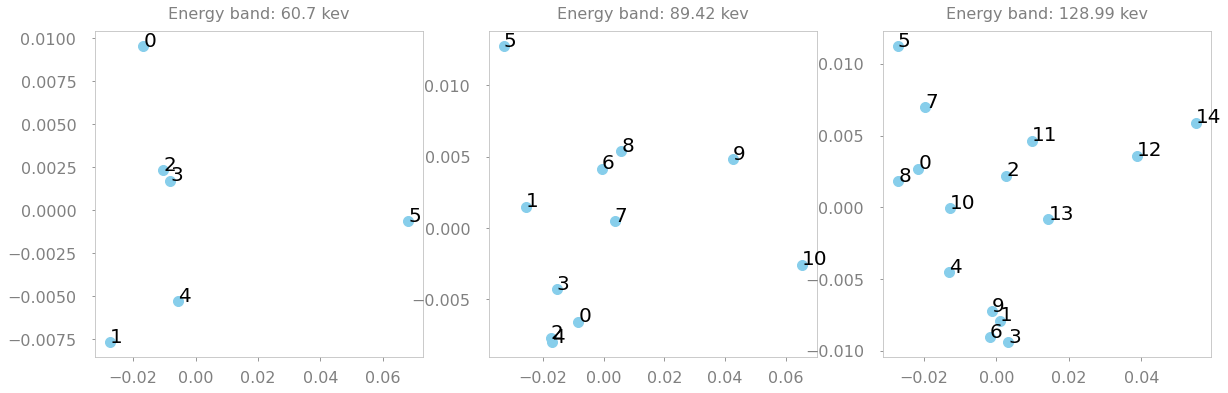

In [8]:
import subprocess
from zedsuite.zutil import Prun, Lsmash
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
plt.rcParams["figure.figsize"] = (20, 6)

# reduce clusters by combining similar ones
new_label_map_list = []
for i, pipeline in enumerate(pipelines):
    # use prun to generate sequences for each PFSA in the established library
    representative_seqs = []
    for pfsa in pipeline.cluster_PFSA_files:
        representative_seqs.append(Prun(pfsafile=pfsa, data_len=pipeline.window_size, num_repeats=10000).run()[0])
        
    # use lsmash and embed results to use pca to map to 2 dimensions
    pd.DataFrame(
        Lsmash(data=pd.DataFrame(representative_seqs), data_type='symbolic', sae=False).run(),
        dtype=np.float32
    ).to_csv(f"for_embedding-{i}", sep=' ', header=False, index=False)
    subprocess.run(["./bin/embed", "-f", f"for_embedding-{i}", "-E", f"embedding-{i}"], capture_output=True)
    pca = PCA(n_components=2)
    embedded_pca = pca.fit_transform(pd.read_csv(f"embedding-{i}", sep=' ', header=None, dtype=np.float32).dropna(how='any', axis=1).T)
    X = embedded_pca.T[0]
    y = embedded_pca.T[1]
    plt.subplot(1, 3, i+1)
    plt.scatter(X, y, s=100, color="skyblue")
        
    # cluster similar PFSAs from pca
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(embedded_pca)
    new_labels = []
    labels_iter = max(clustering.labels_) + 1
    for l in clustering.labels_:
        if l < 0:
            new_labels.append(labels_iter)
            labels_iter += 1
        else:
            new_labels.append(l)

    new_label_map = dict(zip(range(pipelines[i].n_clusters), new_labels))
    new_label_map_list.append(new_label_map)
    
    # for plotting
    annotations = [str(i) for i in range(pipeline.n_clusters)]
    for j, label in enumerate(annotations):
        plt.annotate(label, (X[j], y[j]), fontsize=20)
    
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev',fontsize=16,y=1.02,color='.5')

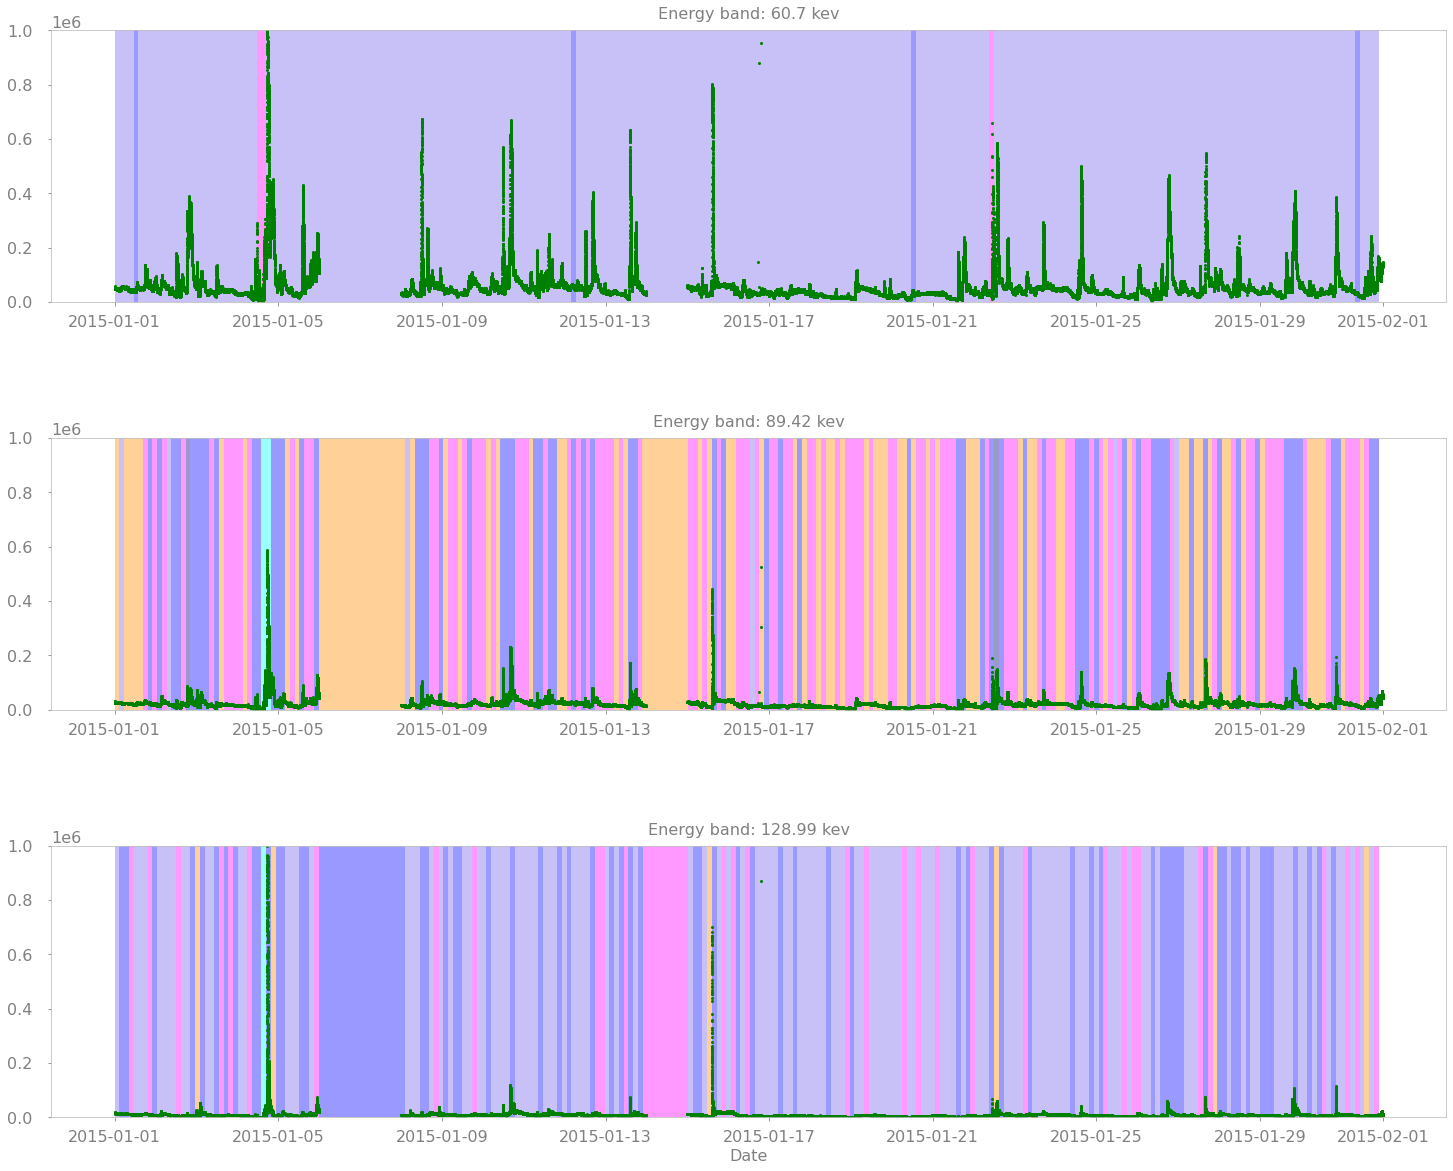

In [9]:
# plot data with updated clusters
plt.rcParams["figure.figsize"] = (25, 20)
plt.subplots_adjust(hspace=.5)
    
start = datetime.strptime(original.iloc[:,0][0], "%Y-%m-%d %H:%M:%S.%f%z")
end = datetime.strptime(original.iloc[:,0][original.shape[0]-1], "%Y-%m-%d %H:%M:%S.%f%z")

dts = pd.DataFrame([datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f%z") for date in original.iloc[:,0][:]])
dts.index = original.index

for i in range(end_col-start_col):
    new_label_map = new_label_map_list[i]
    seqs = original.iloc[:,i+1+start_col].to_frame().replace(-1e+31, np.nan).dropna(how="all", axis=0)
    data = pd.concat([seqs, dts], axis=1).dropna(how="any", axis=0)
    data.columns = ["val", "ts"]
    
    plt.subplot(3, 1, i+1)
    plt.ylim(top=1e6)
    plt.plot_date(data["ts"], data["val"].T.values.tolist(), markersize=2,color='green')
    
    # rank clusters for coloring
    cluster_counts = [0 for j in range(len(new_label_map))]
    for cluster in pipelines[i].closest_match:
        cluster_counts[new_label_map[cluster]] += 1
    cluster_rank = np.flip(np.argsort(cluster_counts))
        
    for index in predictions.index:
        beg = data["ts"].iloc[index * window_size]
        end = data["ts"].iloc[index * window_size + window_size]
        colors = ["#7766ee", "blue", "magenta", "darkorange", 'cyan', "navy", "yellow", "darkgray", "white", "purple", "skyblue"]
        plt.axvspan(beg, end, color=colors[cluster_rank[new_label_map[pipelines[i].closest_match[index]]]], alpha=0.4, lw=0)

        
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
    plt.setp(ax.get_yticklabels(), fontsize=16)
    ax.tick_params(axis='x', colors='.5')    
    ax.tick_params(axis='y', colors='.5',pad=15)  
    ax.yaxis.offsetText.set_fontsize(16)
    ax.spines['bottom'].set_color('.75')
    ax.spines['top'].set_color('.75') 
    ax.spines['right'].set_color('.75')
    ax.spines['left'].set_color('.75')
    ax.set_title('Energy band: '+original.columns[i+1]+' kev',fontsize=16,y=1.02,color='.5')
    if i == end_col-1:
        ax.set_xlabel('Date',fontsize=16, color='.5')
        
plt.savefig('anomaly_result1.png',dpi=300,bbox_inches='tight',transparent=True)

In [10]:
# view PFSAs for pipelines from ContinuousStreamingDetection
from IPython.display import Image, display
from IPython.core.display import HTML
for i, p in enumerate(pipelines):
    print(f"Channel {i+1}\n")
    for i, file in enumerate(p.cluster_PFSA_pngs):
        print(f"\tCluster {i}")
        display(Image(url=f"{file}.png", width=300))

Channel 1

	Cluster 0


	Cluster 1


	Cluster 2


	Cluster 3


	Cluster 4


	Cluster 5


Channel 2

	Cluster 0


	Cluster 1


	Cluster 2


	Cluster 3


	Cluster 4


	Cluster 5


	Cluster 6


	Cluster 7


	Cluster 8


	Cluster 9


	Cluster 10


Channel 3

	Cluster 0


	Cluster 1


	Cluster 2


	Cluster 3


	Cluster 4


	Cluster 5


	Cluster 6


	Cluster 7


	Cluster 8


	Cluster 9


	Cluster 10


	Cluster 11


	Cluster 12


	Cluster 13


	Cluster 14
